In [2]:
# !git clone https://github.com/hyperforest/seisbench.git
# !pip install -e seisbench

In [3]:
import numpy as np
from pathlib import Path as _Path
from torchsummary import summary
import torch

%load_ext autoreload
%autoreload 2
import seisbench
import seisbench.data as sbd
import seisbench.models as sbm
import matplotlib.pyplot as plt
import copy
from utils import Solver, ProbabilisticLabeller
from blocks import *
import logging
from leqnet import LEQNet

seisbench.cache_root = _Path("../")
seisbench.cache_data_root = _Path("../datasets/")
seisbench.cache_model_root = seisbench.cache_root / 'models' / 'v3'
# seisbench.remote_model_root = 'https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/models/v3/'
# seisbench.config = {'dimension_order': 'NCW', 'component_order': 'ZNE'}
# seisbench.__version__ = '0.5.2'

# logger = logging.getLogger('seisbench')
# logger.setLevel(logging.INFO)
# seisbench.logger = logger


In [4]:
data = sbd.Iquique(sampling_rate=100)
df_meta = data.metadata
mask = (~df_meta['trace_P_arrival_sample'].isna() &
        ~df_meta['trace_S_arrival_sample'].isna())

data.filter(mask)
train, dev, test = data.train_dev_test()


2023-10-09 15:15:02,135 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb


5946


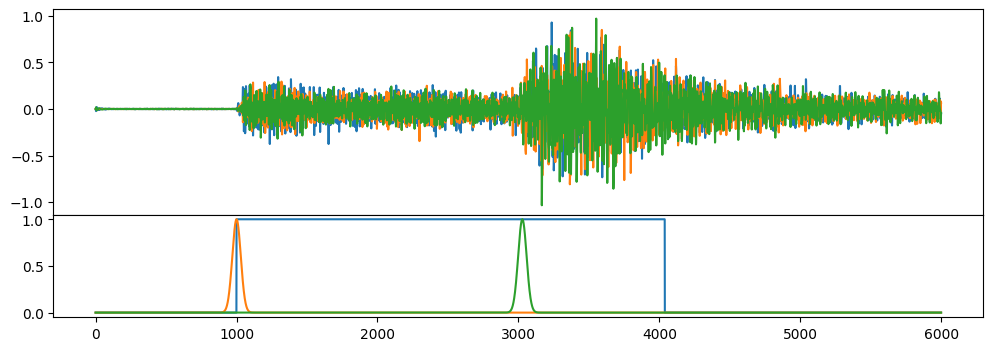

In [5]:
import seisbench.generate as sbg
phase_dict = {
    "trace_P_arrival_sample": "P",
    "trace_S_arrival_sample": "S"
}

train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)
test_generator = sbg.GenericGenerator(test)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=1000, windowlen=6000, selection="first", strategy="pad"),
    sbg.RandomWindow(windowlen=6000, strategy="move"),
    sbg.Normalize(demean_axis=-1, detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.Filter(btype='bandpass', Wn=[2,25], N=6),
    sbg.ChangeDtype(np.float32),
    # sbg.GaussianNoise(scale=(0, 0.15)),
    ProbabilisticLabeller(label_columns=phase_dict, sigma=30, dim=1, use_detection=True, spectrogram_based=True)
]


train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)
test_generator.add_augmentations(augmentations)

n = np.random.randint(len(train_generator))
# n=1175
print(n)
sample = train_generator[n]

fig = plt.figure(figsize=(12, 4))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [2, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)
plt.show()

In [6]:
pt_data = "iquique"
model_pt = sbm.EQTransformer.from_pretrained(pt_data, update=True)
model_base = sbm.EQTransformer()

model_eqt = copy.deepcopy(model_pt)
model_leq = copy.deepcopy(model_pt)

# replace encoder and decoder using separable conv1d
model_eqt.encoder = model_base.encoder
model_leq.encoder = EncoderSepConv1d(
            input_channels=model_pt.in_channels,
            filters=model_pt.filters,
            kernel_sizes=model_pt.kernel_sizes,
            in_samples=model_pt.in_samples
)

decoder = DecoderSepConv1d(
    input_channels=16,
    filters=model_pt.filters[::-1],
    kernel_sizes=model_pt.kernel_sizes[::-1],
    out_samples=model_pt.in_samples,
)

model_eqt.decoder_d = model_base.decoder_d 
model_leq.decoder_d = decoder
pick_decoders = [decoder for _ in range(2)]
model_eqt.pick_decoders = nn.ModuleList(pick_decoders)
model_leq.pick_decoders = nn.ModuleList(pick_decoders)

# replace res cnn stack to deeper bottleneck
model_eqt.res_cnn_stack = model_base.res_cnn_stack
model_leq.res_cnn_stack = DeeperBottleneckStack(
  kernel_sizes=model_pt.res_cnn_kernels,
  filters=model_pt.filters[-1],
  drop_rate=model_pt.drop_rate,
)

# replace single head to multi head transformer
Transformer = MultiHeadTransformerPreLN
num_heads = 4

model_eqt.transformer_d0 = model_base.transformer_d0
model_leq.transformer_d0 = Transformer(
  input_size=16, drop_rate=model_pt.drop_rate, num_heads=num_heads, eps=1e-5
)

model_eqt.transformer_d = model_base.transformer_d
model_leq.transformer_d = Transformer(
  input_size=16, drop_rate=model_pt.drop_rate, num_heads=num_heads, eps=1e-5
)

# pick_attentios = [nn.MultiheadAttention(embed_dim=16, num_heads=num_heads) for _ in range(2)]
# model_eqt.pick_attentions = model_base.pick_attentions
# model_leq.pick_attentions = nn.ModuleList(pick_attentios)

for model in [model_leq, model_eqt]:
  for name, param in model.named_parameters():
    if 'lstm' in name:
      param.requires_grad = False


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register count_lstm() for <class 'torch.nn.modules.rnn.LSTM'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.Upsample'>.
Netscore already calculated



Saving plot..:   0%|          | 0/54 [00:00<?, ?it/s]

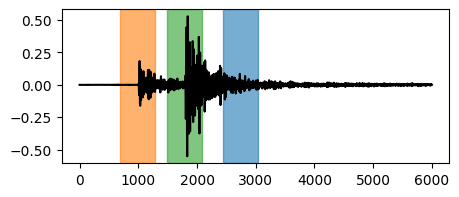

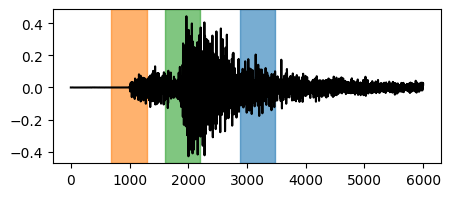

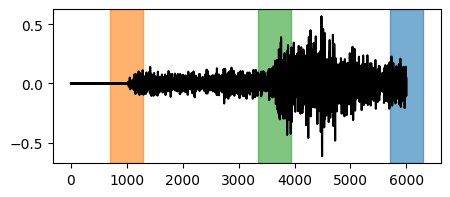

d:\Thesis\code\notebooks\utils.py:153: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5,2))
Saving plot..:   2%|▏         | 1/54 [00:18<16:04, 18.19s/it]


KeyboardInterrupt: 

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

<Figure size 500x200 with 0 Axes>

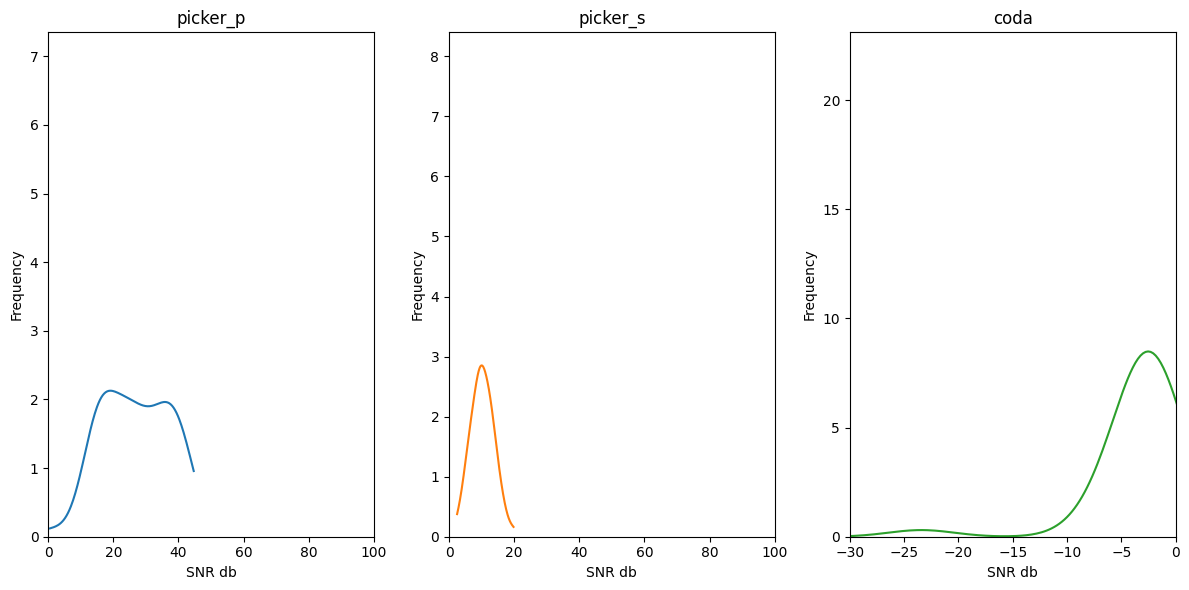

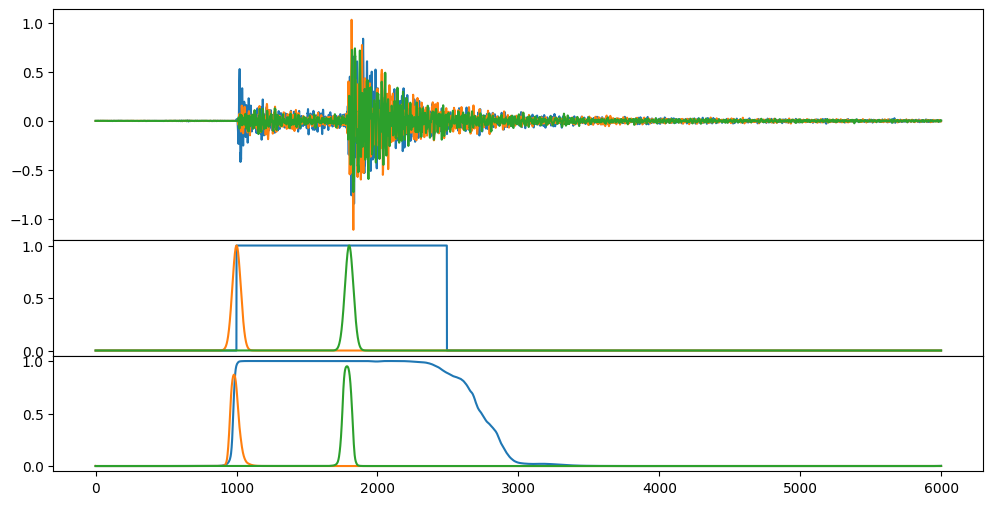

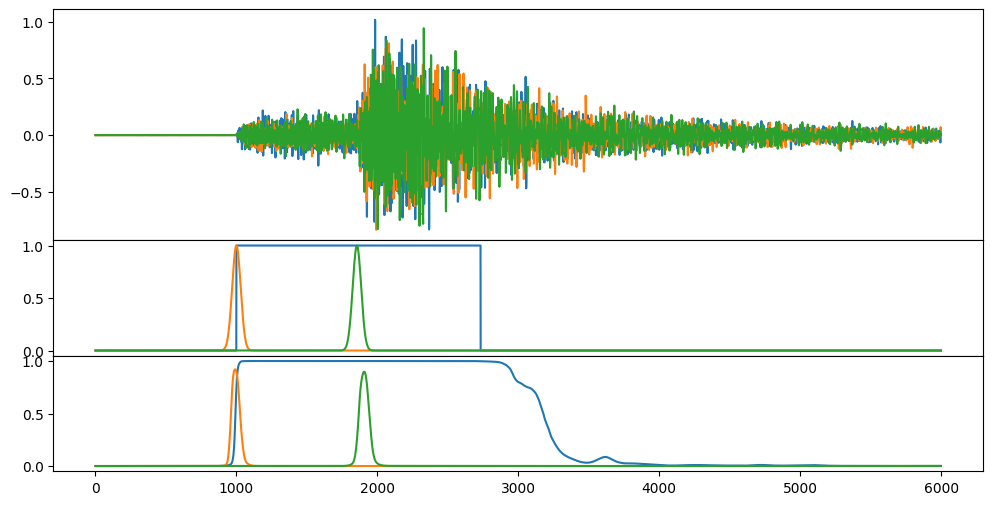

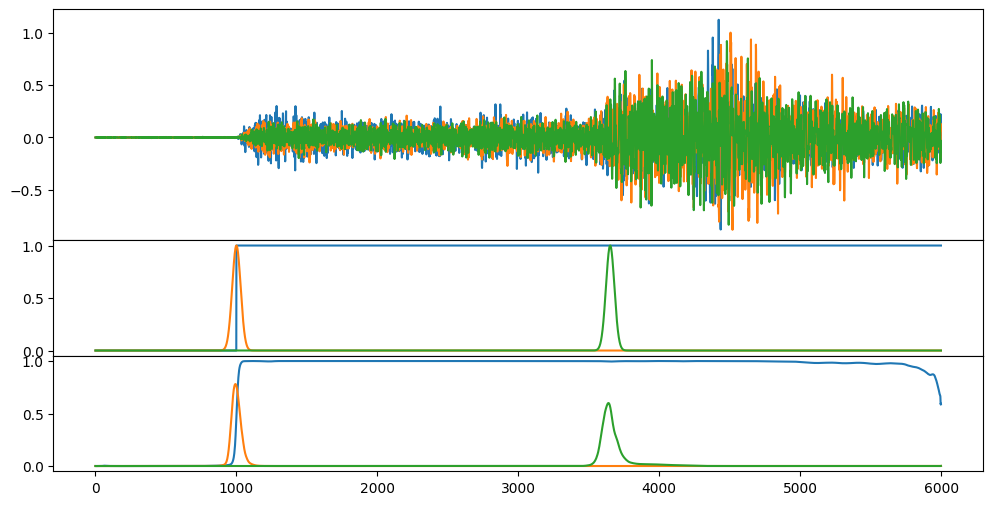

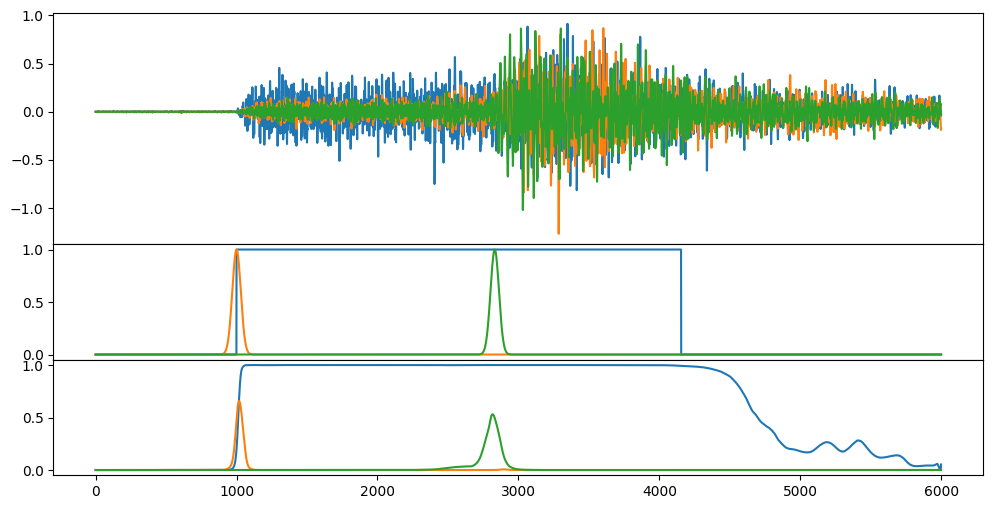

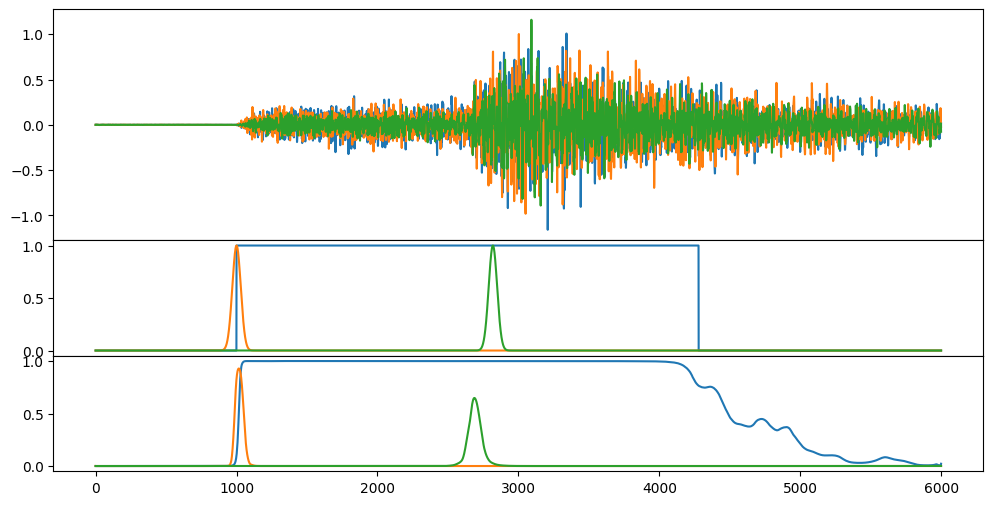

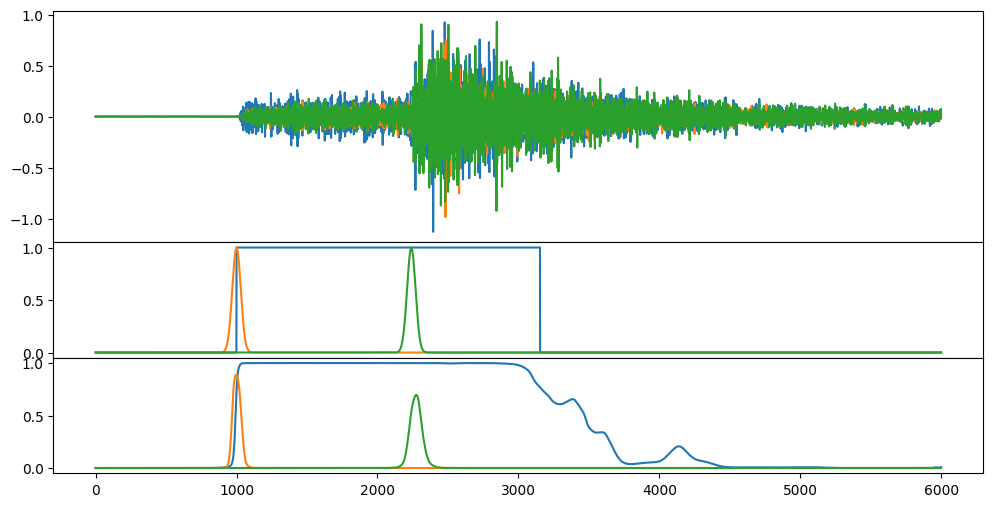

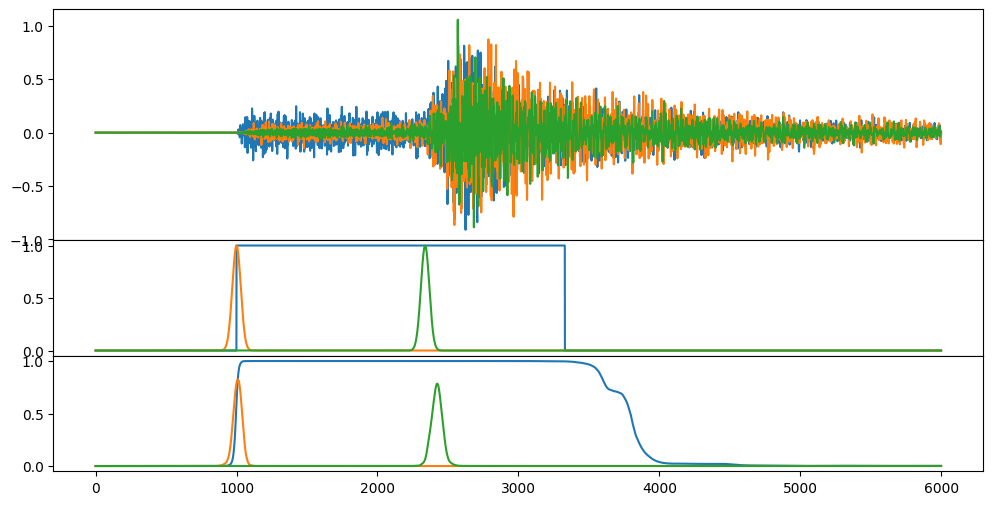

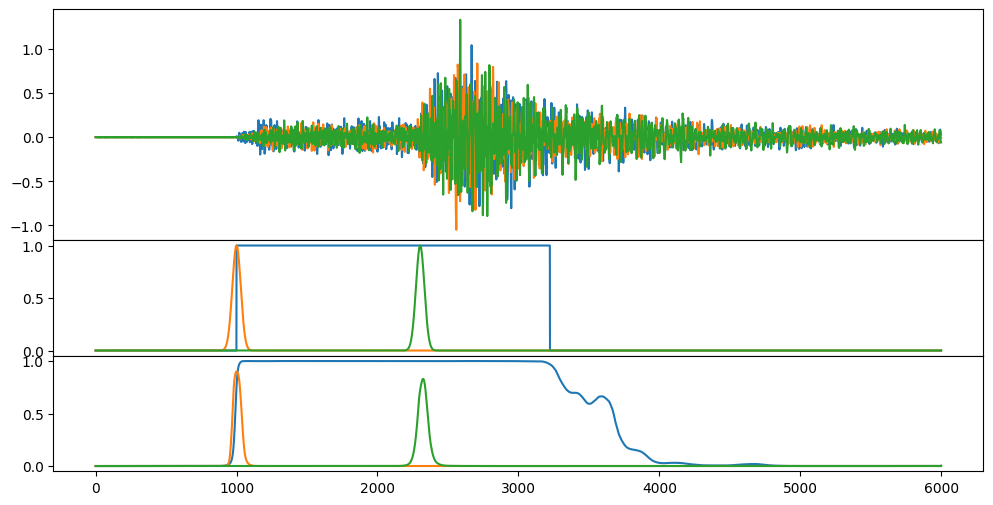

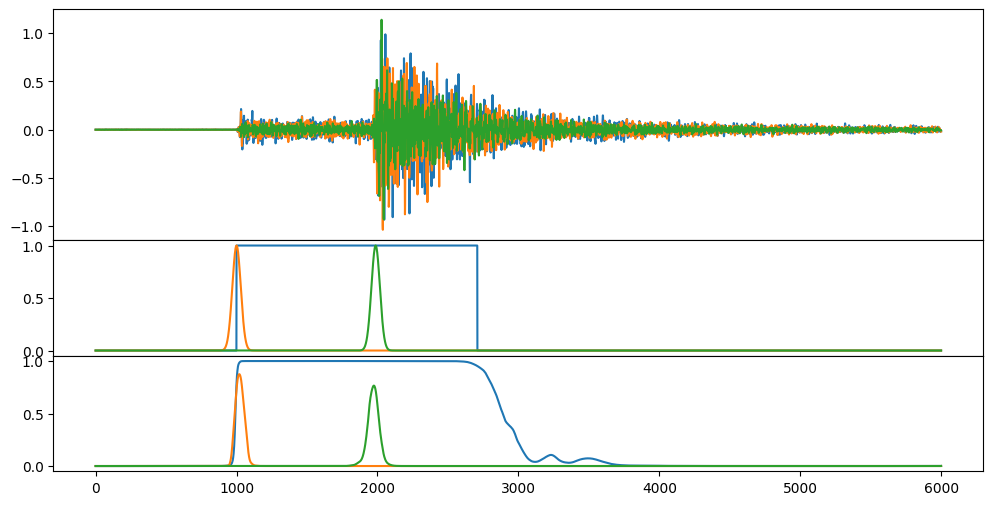

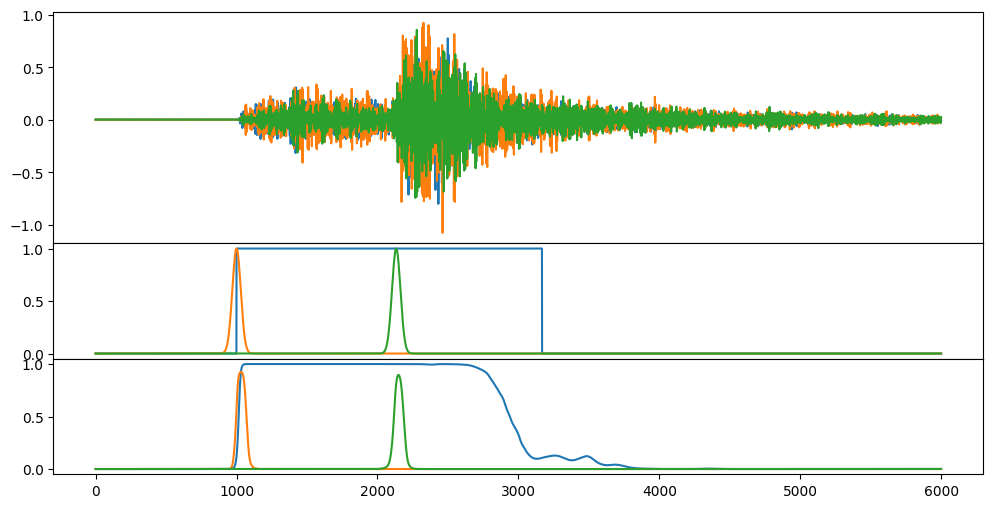

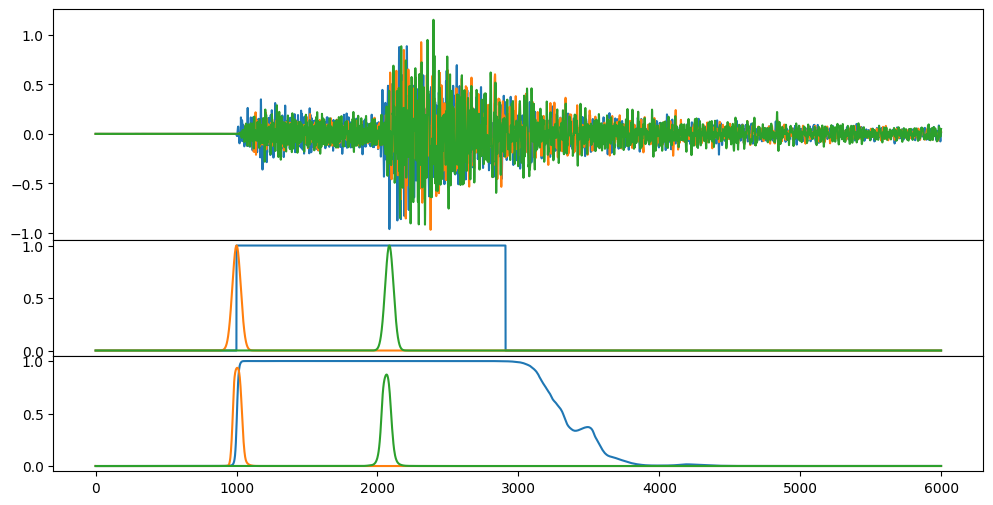

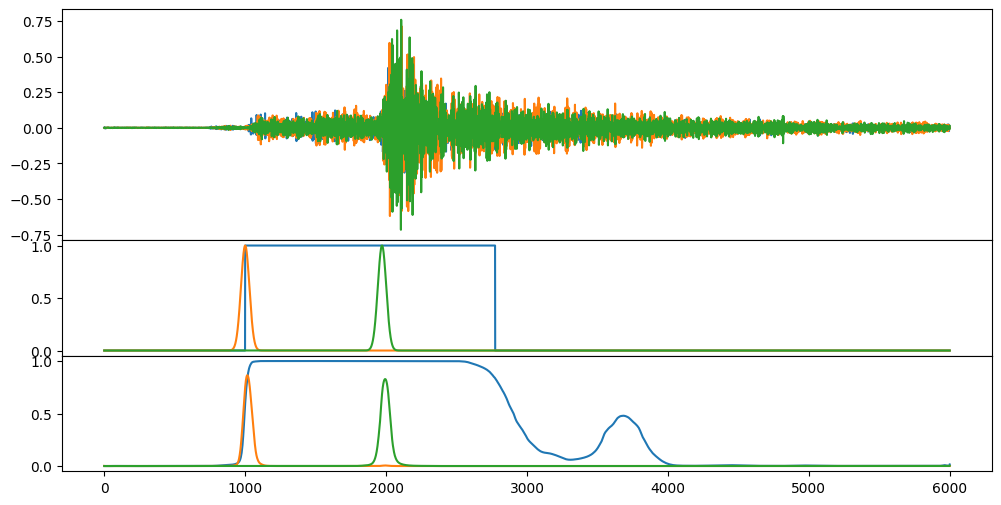

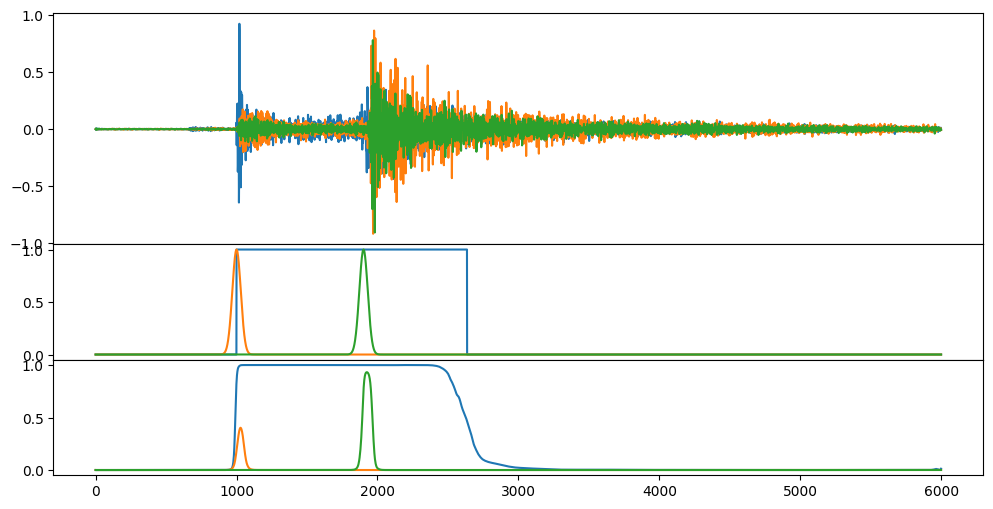

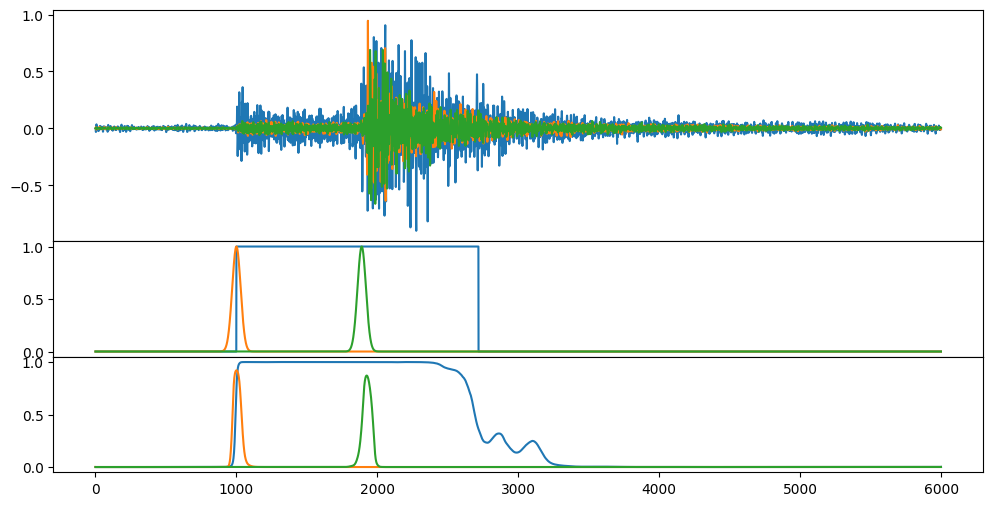

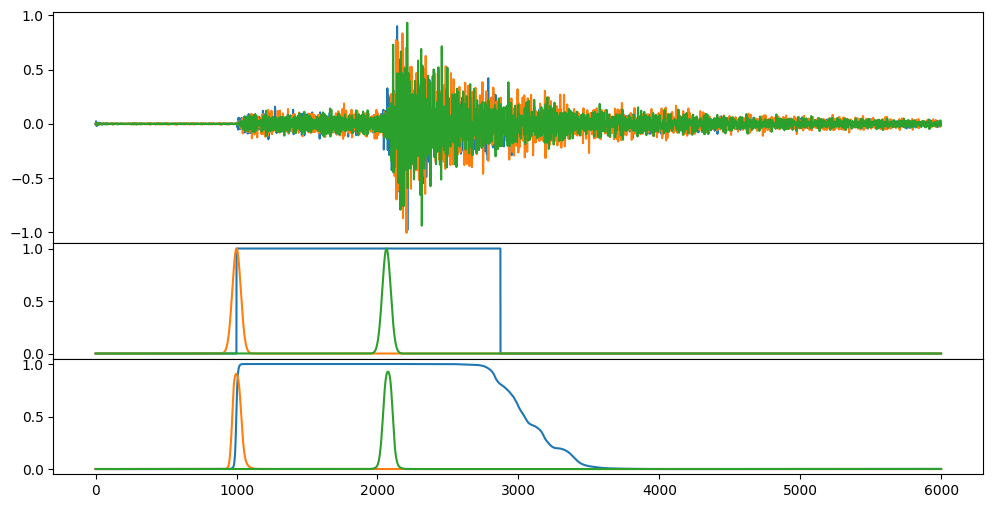

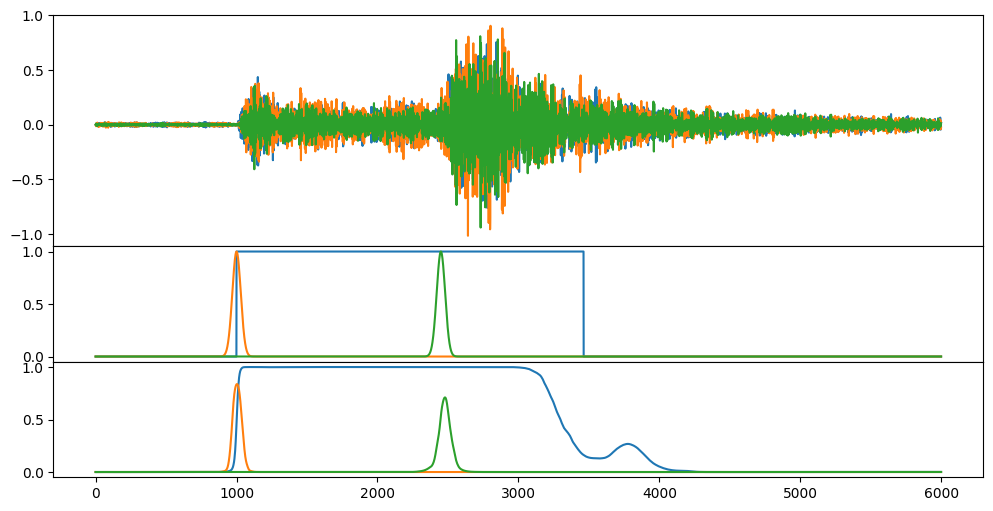

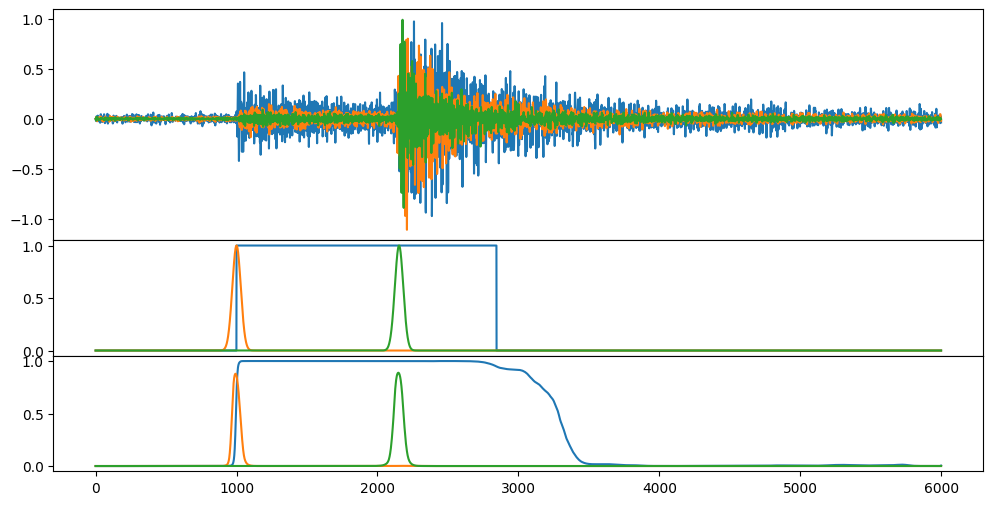

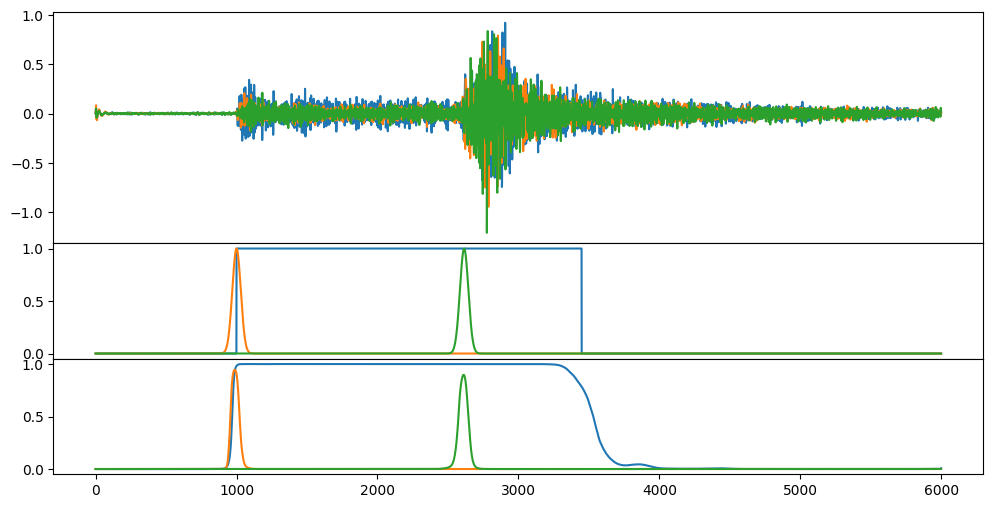

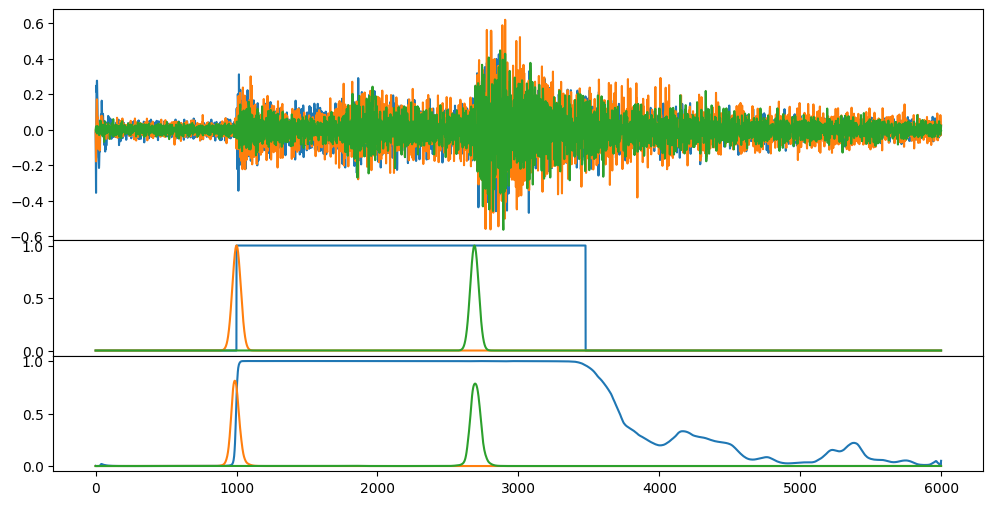

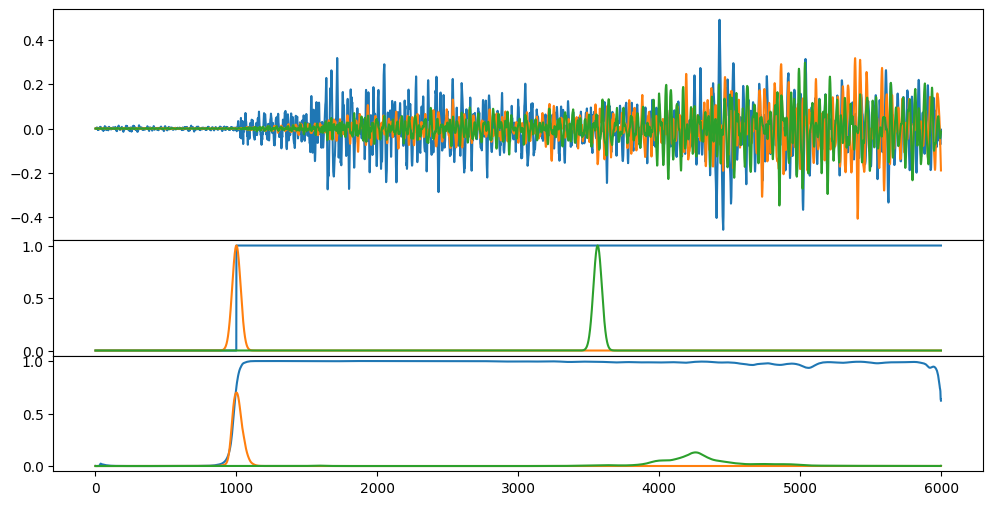

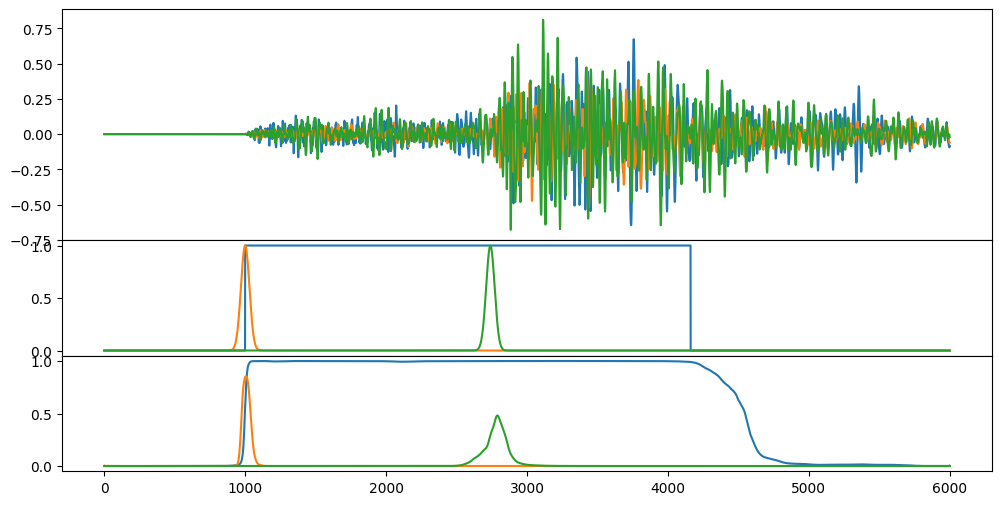

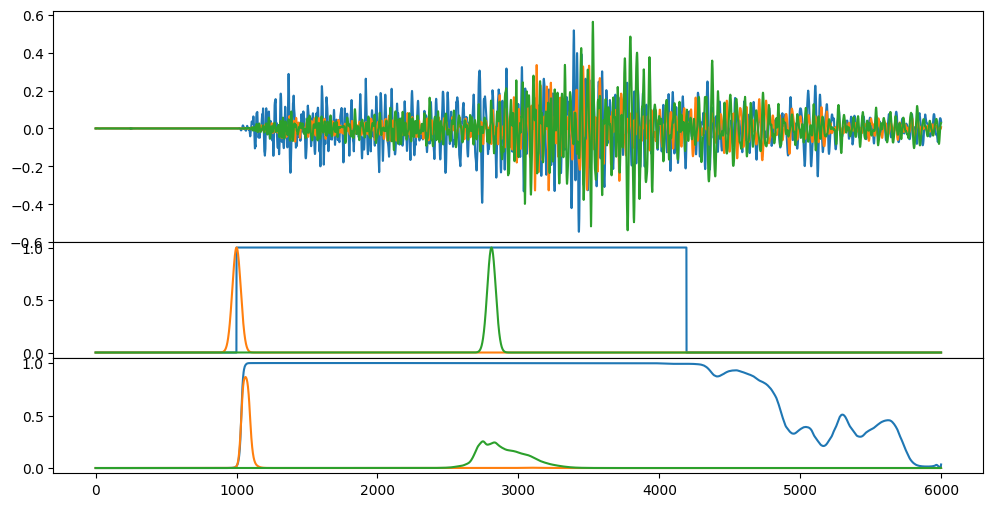

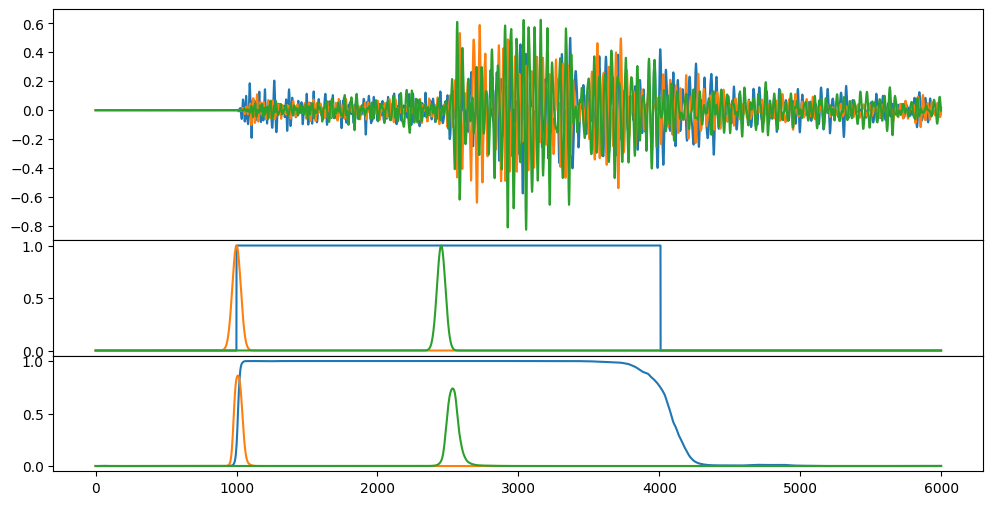

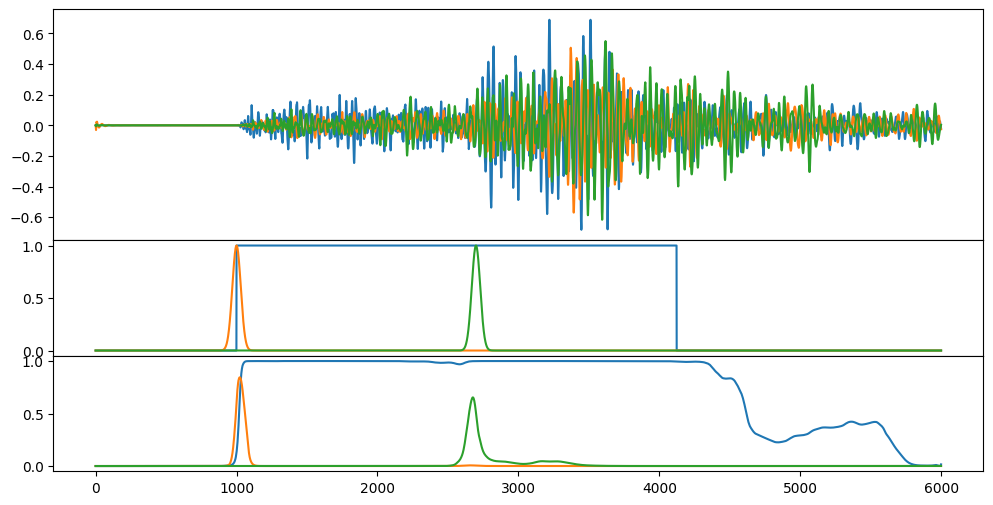

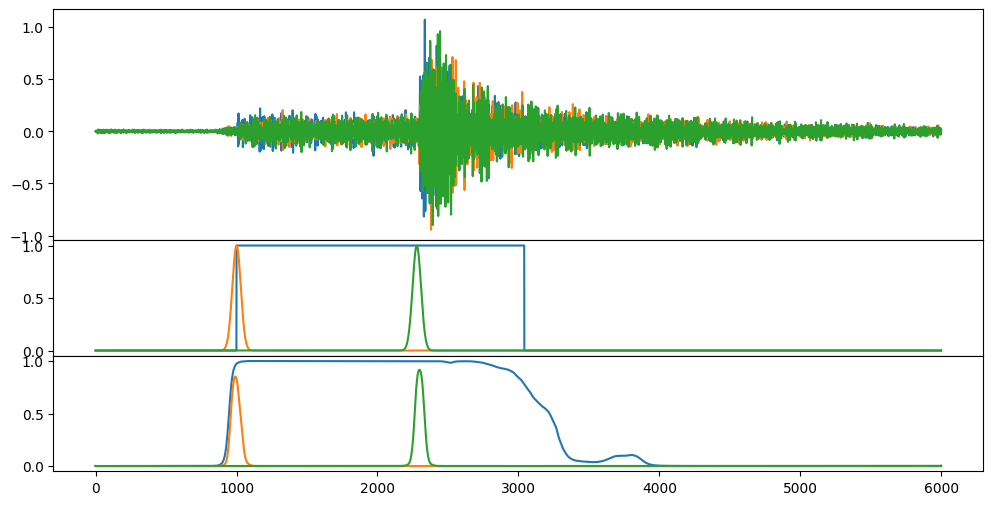

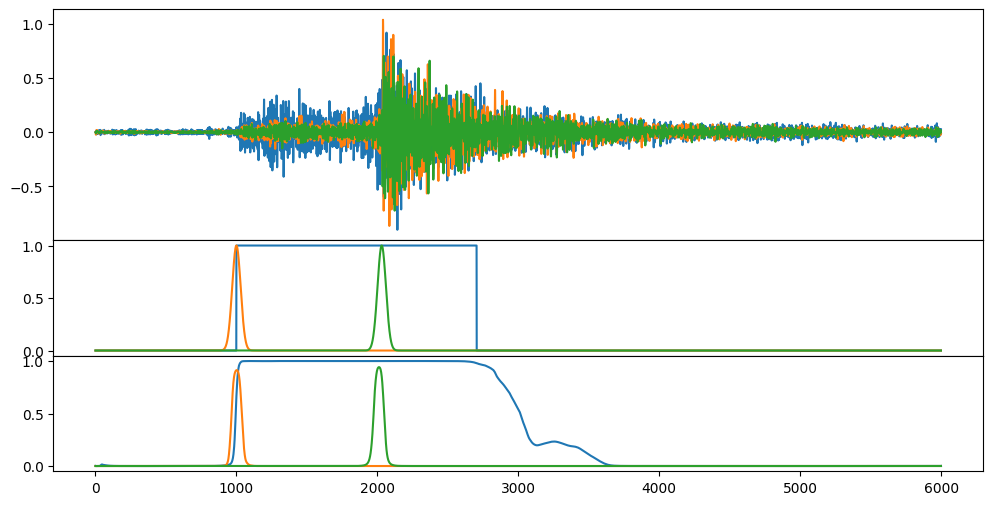

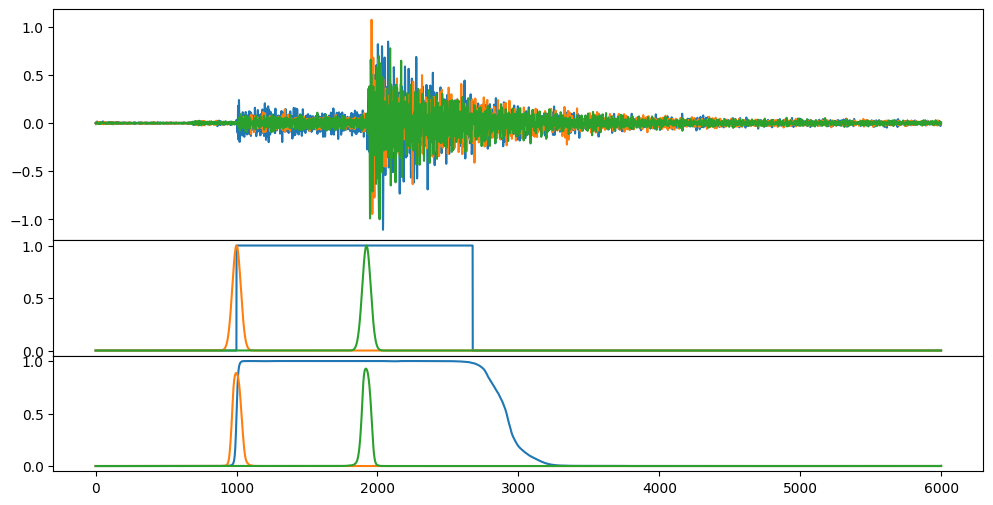

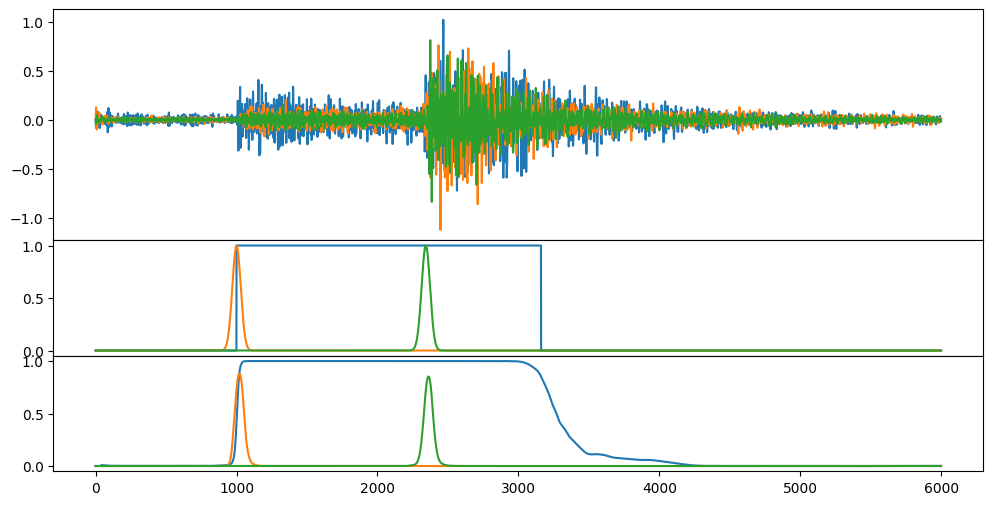

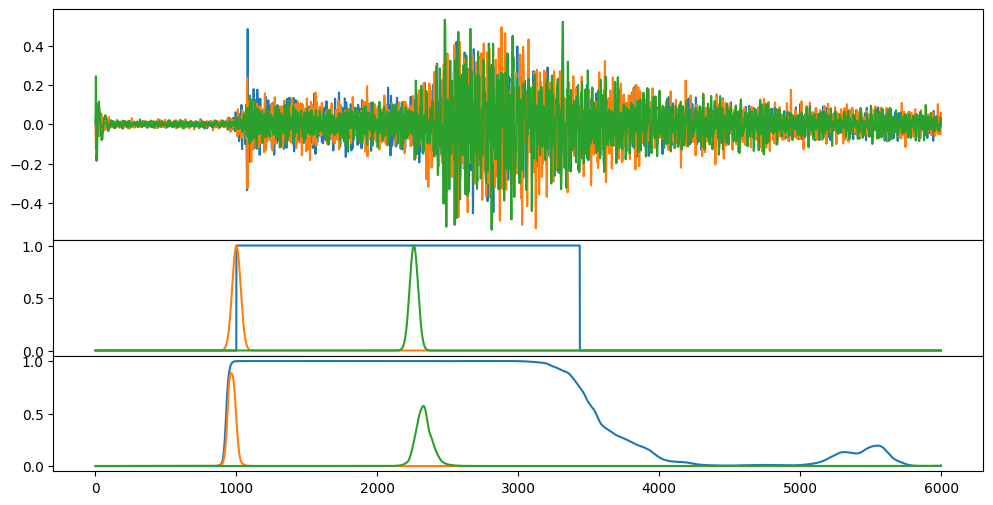

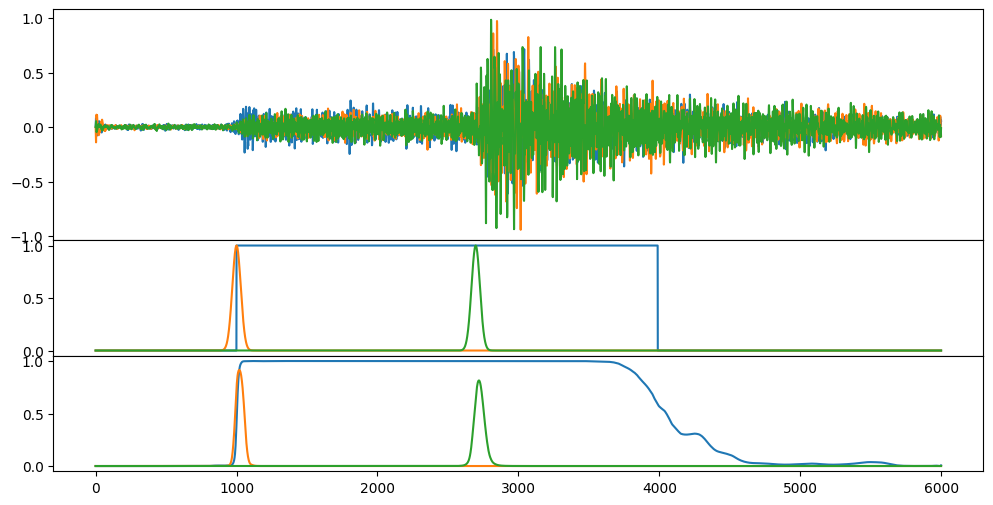

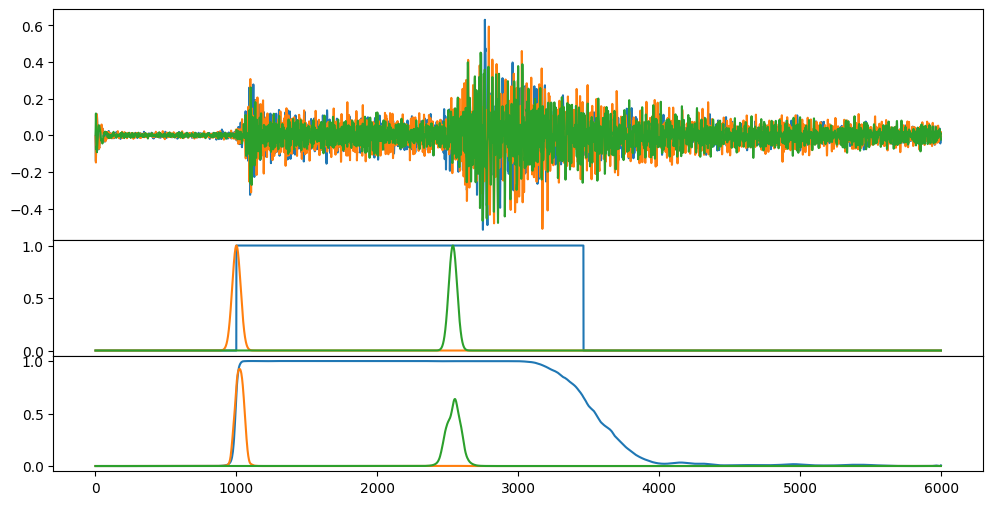

In [7]:
folder_name = f'{pt_data}/LEQNet+_bs32_sigma30'
model = model_leq

config = dict(
  main = dict(
    batch_size=64, 
    folder_name=folder_name,
    class_weights=[.03, .40, .58],
    patience=6
    ),
  train = dict (
    model= model, 
    learning_rate=1e-3,
    epochs=10,
    print_every_batch=15,
  ),
  test = dict(
    model_path=folder_name,
    model_base = LEQNet(),
    plot_batch_id = [i for i in range(64)]
  )
)

solver = Solver(train_generator, dev_generator, test_generator, **config['main'])
# solver.train(**config['train'])
solver.test(**config['test'])

In [ ]:

import seaborn as sns
fig, ax = plt.subplots(1,3, figsize=(12,6))
for i, data in enumerate([solver.snr_p, solver.snr_s, solver.snr_d]):
    hist = sns.histplot(data, ax=ax[i], bins=40, alpha=0, kde=True, color=f'C{i}')
    for patch in hist.patches:
        patch.set_alpha(0)


label = ['picker_p', 'picker_s', 'coda']
for n in range(3):
    xlim = [0,100] if n<2 else [-30,0]
    ylim = [0,(len(solver.test_loader)*solver.batch_size)//4]
    ax[n].set_xlim(xlim)
    ax[n].set_ylim(ylim)
    ax[n].set_xlabel('SNR db')
    ax[n].set_ylabel('Frequency')
    ax[n].set_title(label[n])
plt.tight_layout()
plt.savefig(solver.folder_path / f'test/dist_SNR.png')

In [ ]:
!pip install seaborn